<a href="https://colab.research.google.com/github/jhanv/Cypto_RoboAdvisor/blob/main/Sentiment_Analysis_BTC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CryptoCurrency Sentiment Analysis (Bitcoin)

This Notebook consists of code for the data cleaning, maniplication and extraction of sentimental analysis of Reddit posts which contains word "Bitcoin" from 2009 to 2019 and the google trends data from 2014-2020 and the twitter posts count of Bitcoin mentions.
This data combined will be later used along with the market data to predict the Bitcoin. 

This extraction process can also be used for the other coins given the data (from reddit/ twitter) is avaialble.

## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pytrends
!pip install transformers
!pip install fasttext
!apt install enchant
!pip install pyenchant

Reading package lists... Done
Building dependency tree       
Reading state information... Done
enchant is already the newest version (1.6.0-11.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
import time
import pandas as pd  
import numpy as np
import string       
import re    
from wordcloud import WordCloud, STOPWORDS 
import nltk # preprocessing text
nltk.download('stopwords')


import matplotlib.pyplot as plt

from pytrends.request import TrendReq
from pytrends import dailydata as dd

from transformers import pipeline
import zipfile


import requests 
from bs4 import BeautifulSoup
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import nltk # preprocessing text
nltk.download('stopwords')
nltk_stopwords = nltk.corpus.stopwords.words('english')

import enchant
d = enchant.Dict("en_US")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Reddit Data

The [Reddit posts data](https://www.kaggle.com/jerryfanelli/reddit-comments-containing-bitcoin-2009-to-2019) is obtained from Kaggle. 
Reddit Comments Containing "Bitcoin" 2009 to 2019
4M+ Comments from Reddit that contain the word "bitcoin" from 2009 to 2019 collected from Google BigQuery. 

In [ ]:
zf = zipfile.ZipFile('/content/drive/MyDrive/CIS 522 Final Project/Data/bitcoin_reddit_all.csv.zip') 
df = pd.read_csv(zf.open('bitcoin_reddit_all.csv'))

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2,3,4,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df.columns

Index(['Unnamed: 0', 'datetime', 'date', 'author', 'subreddit', 'created_utc',
       'score', 'controversiality', 'body'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4309244 entries, 0 to 4309243
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Unnamed: 0        object 
 1   datetime          object 
 2   date              object 
 3   author            object 
 4   subreddit         object 
 5   created_utc       float64
 6   score             float64
 7   controversiality  float64
 8   body              object 
dtypes: float64(3), object(6)
memory usage: 295.9+ MB


In [ ]:
df.isnull().sum()

Unnamed: 0          65536
datetime            65695
date                65695
author              65695
subreddit           65695
created_utc         65695
score               65702
controversiality    65695
body                65695
dtype: int64

#### Data Cleaning

In [ ]:
df["len_post"] = df["body"].apply(lambda line:len(str(line)))
df["body"] = df["body"].apply(lambda line : line if type(line) == str else np.nan )

In [ ]:
df.dropna(subset = ["body", "score", "controversiality", "date"], inplace = True)

In [ ]:
%%time

def replace_gibberish(text):
  "Replces the text with more than certain word length and wrong spelling in English"
  lst = []
  for word in text.split():
    if len(word) >= 20:
      continue
    else:
      lst.append(word)
    
  return " ".join(lst)

# df["body"] = df["body"].apply(lambda text : replace_gibberish(text))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs


In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [ ]:
def clean_text(text, rmstop = False):
  """
  Input : The text or sentence/s to be cleaned and if stopwords has to be removed or not
  --> text : string
  --> rmstop : bool
  Cleans the text by 
  # - Converting text to lowercase,
  - Mapping contracts to full text,
  - Remove text in paranthesis,
  - Remove specific special characters
  - Remove newline character
  Output : Cleand text or sentence/s
  """
 
  txt = re.sub('[0-9\n]','',text)
  txt = txt.replace("&gt", "")
  txt = re.sub(r"http\S+", "", txt)
  txt = ' '.join([contraction_mapping[word] if word in contraction_mapping else word for word in txt.split(" ")])
  txt = re.sub(r'[^\w\s]', '',txt)
  txt = re.sub(r'\([^)]*\)', '', txt)
  txt = re.sub('"', '', txt)
  txt = txt.replace("\\", "")
  txt = re.sub(r"'s\b","",txt)
  txt = txt.rstrip().lstrip();
  nltk_sw = set(nltk_stopwords).union(stopwords)
  if rmstop:
    tokens = [word for word in txt.split() if not word in set(nltk_sw)]
  else:
    tokens = txt.split()
  
  return (" ".join(tokens)).strip()

In [ ]:
%%time
df["body"] = df["body"].apply(lambda subject : replace_gibberish(subject))
# CPU times: user 1min 48s, sys: 5.16 s, total: 1min 53s

CPU times: user 1min 6s, sys: 1.68 s, total: 1min 8s
Wall time: 1min 8s


##### Fast text for replacing other languages with english

In [ ]:
# Downloading pretrained model for fasttext
!wget -O /tmp/lid.176.bin https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin

--2021-05-02 22:21:47--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131266198 (125M) [application/octet-stream]
Saving to: ‘/tmp/lid.176.bin’

/tmp/lid.176.bin    100%[===================>] 125.18M  52.8MB/s    in 2.4s    

2021-05-02 22:21:50 (52.8 MB/s) - ‘/tmp/lid.176.bin’ saved [131266198/131266198]



In [ ]:
import fasttext

PRETRAINED_MODEL_PATH = '/tmp/lid.176.bin'
model_lang = fasttext.load_model(PRETRAINED_MODEL_PATH)

In [ ]:
sentences = ['jInvestopedia cites some boosterism which cites an article in kommersantru Авиабилеты оплатят по блокчейну авиакомпания S и ее крупнейший агент S Билет с понедельника запускают проект по продаже авиабилетов на блокчейне Ethereum сообщили Ъ в Альфабанке Система платежей на основе обеспечивает поступление выручки от продажи за вычетом комиссии агента сразу после оформления авиабилета отметили в банке Взаиморасчеты по традиционной схеме занимают около двух недель the Google translation of which is in its entirety Flights will be paid for the blockage AlfaBank the airline S and its largest agent S Ticket launched a project to sell air tickets on Ethereum block starting Monday Kommersant reported to AlfaBank The system of payments on the basis of the blockplatform ensures receipt of proceeds from sales minus the commission of the agent immediately after issuing the air ticket the bank noted Mutual settlements according to the traditional scheme take about two weeks Thats literally the whole source This has to come from somewhere else but theres no clues as to where The Russian press on a Google for S Билет Ethereum siteru turns up more copies of the Kommersant article or cites to American rebloggings of the same story The actual source a press talking about an internal blockchain trial Kommersant were the only outlet who ran this And so the Bitcoin boosterism game of media telephone continues']
predictions = model_lang.predict(sentences)
print(predictions)

([['__label__en']], [array([0.39937377], dtype=float32)])


In [ ]:
%%time
def detect_robust(x):

    out = model_lang.predict(x) 
    if out[0] != ('__label__en',):
      text = "Assumption Good Bitcoin in another language"
    elif out[1][0] < 0.95:
      text = "Bitcoin" 
    else:
      text = x
    return text

comb = df['body'].map(detect_robust)

# CPU times: user 46.7 s, sys: 514 ms, total: 47.2 s - 1000000 instances
# CPU times: user 3min 6s, sys: 635 ms, total: 3min 6s TO RUN

CPU times: user 3min 22s, sys: 824 ms, total: 3min 23s
Wall time: 3min 22s


In [ ]:
df["post"] = comb

In [ ]:
nltk_stopwords = nltk.corpus.stopwords.words('english')
punctuations = list(string.punctuation)
stopwords = set(nltk_stopwords).union(punctuations)

In [ ]:
%%time
df["post"] = df["post"].apply(lambda text : clean_text(text))

# CPU times: user 4min 13s, sys: 2.72 s, total: 4min 16s

CPU times: user 3min, sys: 1.13 s, total: 3min 1s
Wall time: 3min 1s


In [ ]:
df.columns

Index(['Unnamed: 0', 'datetime', 'date', 'author', 'subreddit', 'created_utc',
       'score', 'controversiality', 'body', 'len_post', 'post'],
      dtype='object')

#### Data Visualization

##### Correlation Matrix

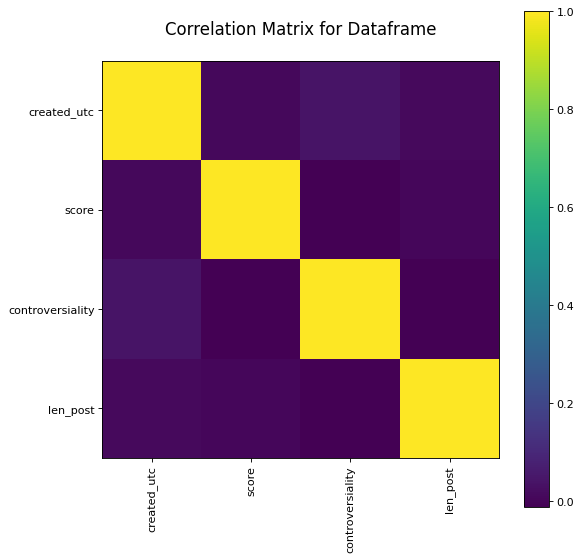

In [ ]:
def plotCorrelationMatrix(df, graphWidth):
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for Dataframe', fontsize=15)
    plt.show()

# Plot Correlation Matrix
plotCorrelationMatrix(df, 8)

##### Distribution Plot + Filtering

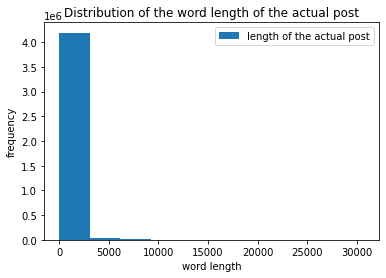

In [ ]:
def dist_plot(data, label, title) :
  """
  Input : dataframe, labels to be given to the plot, title of the plot
  For plotting the distribution of the data of any column/s usinng historgram 
  """
  plt.hist(data, label = label)
  plt.xlabel("word length")
  plt.ylabel("frequency")
  plt.title(title)
  plt.legend()
  plt.show()

dist_plot([df["len_post"]], ["length of the actual post"], "Distribution of the word length of the actual post")

In [ ]:
print("0.972 percentile of the length of the actual post is", df['len_post'].quantile(q = 0.972))

0.972 percentile of the length of the actual post is 2047.8519999999553


Filtering out the text whose length is not in 97 %

In [ ]:
df = df[df["len_post"] <= df['len_post'].quantile(q = 0.97)] 

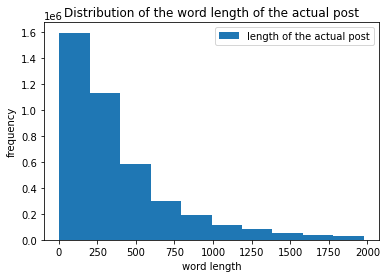

In [ ]:
dist_plot([df["len_post"]], ["length of the actual post"], "Distribution of the word length of the actual post")

Controversality distribution

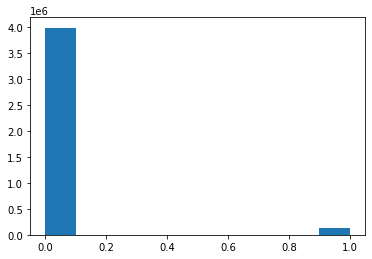

In [ ]:
 plt.hist(df["controversiality"])
 plt.xlabel("controversality score")
 plt.ylabel("Frequency")
 plt.title("Controversiality Distribution")
 plt.show()

In [ ]:
# Scatter and density plots

def plotScatterMatrix(data, plotSize, textSize):
    data = data.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to data being singular
    data = data.dropna('columns')
    data = data[[col for col in data if data[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(data)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    data = data[columnNames]
    ax = pd.plotting.scatter_matrix(data, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = data.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

# Takes more than 10 mins

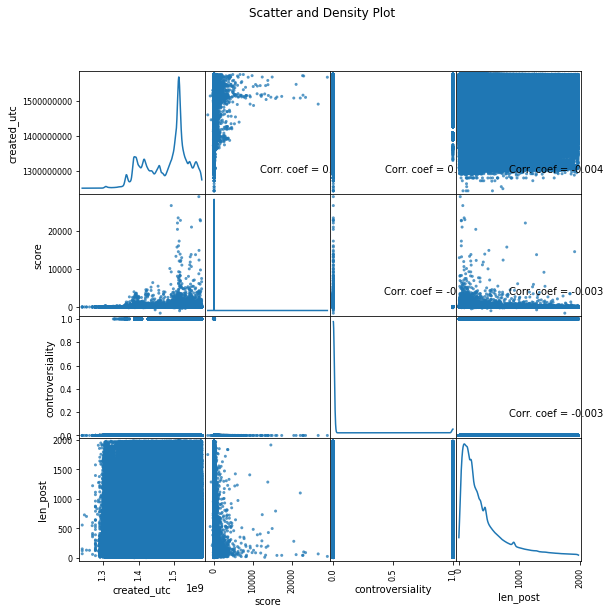

In [ ]:
plotScatterMatrix(df, 9, 10)

##### Word Cloud

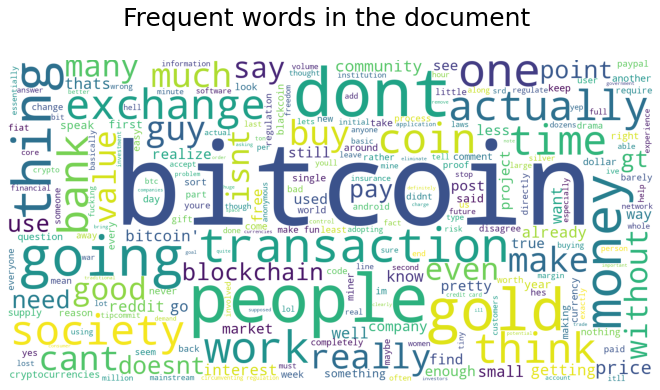

In [ ]:
nltk_stopwords = nltk.corpus.stopwords.words('english')
punctuations = list(string.punctuation)
stopwords = set(nltk_stopwords).union(punctuations)

# Function to remove the stopwords and punctuations
def preprocess(x):
    """
    Function to remove the stopwords and punctuations
    """
    x = str(x)
    x = re.sub('[^a-z\s]', '', x.lower())                  
    x = [w for w in x.split() if w not in set(stopwords)]  
    return ' '.join(x)

post = df['body'][:100].apply(preprocess)
wordcloud = WordCloud(width=1600, height=800, random_state=2, max_words=250, background_color='white',)
wordcloud.generate(str(set(post)))
# declare our figure 
plt.figure(figsize=(16,8))
plt.title("Frequent words in the document \n", fontsize=25, color='black')
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=10)
plt.show()


In [ ]:
df.to_csv("/content/drive/MyDrive/CIS 522 Final Project/reddit_cleaned.csv")

In [ ]:
for i in df[:100]["post"]:
  print(i)

### Sentimental Analysis (Pretrained)

In [ ]:
sentiment_analysis = pipeline("sentiment-analysis", device = 0)

In [ ]:
pos_text = "I enjoy studying computational algorithms."
neg_text = "I dislike sleeping late everyday."

In [ ]:
result = sentiment_analysis(pos_text)[0]
print("Label:", result['label'])
print("Confidence Score:", result['score'])
print()
result = sentiment_analysis(neg_text)[0]
print("Label:", result['label'])
print("Confidence Score:", result['score'])

Label: POSITIVE
Confidence Score: 0.9980718493461609

Label: NEGATIVE
Confidence Score: 0.9881595969200134


In [ ]:
from csv import DictWriter
def append_dict_as_row(file_name, dict_of_elem, field_names):
    # Open file in append mode
    with open(file_name, 'a+', newline='') as write_obj:
        # Create a writer object from csv module
        dict_writer = DictWriter(write_obj, fieldnames=field_names)
        # Add dictionary as wor in the csv
        dict_writer.writerow(dict_of_elem)

In [ ]:
df["post"][3911505] = "Average Bitcoin"

In [ ]:
df["post"][4192246] = "Negative Bitcoin"

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
start = time.time()
# data = df[:10000]

try :
  data_new = pd.read_csv('/content/drive/MyDrive/CIS 522 Final Project/Data/reddit_data.csv')
  next_row = data_new.iloc[-1][0] + 1
  del data_new
except :
  next_row = 0

for i, row in df.iterrows():
  if i < next_row :
    continue
  text = row['post']
  result = sentiment_analysis(text)[0]
  if  result['label'] == "POSITIVE":
    label = 1
  else :
    label = -1
  if i % 10000 == 0:
    print(i, len(text), result['label'], result['score'])
    # file loc /content/drive/MyDrive/CIS 522 Final Project/test.csv renmae it to your own
  append_dict_as_row('/content/drive/MyDrive/CIS 522 Final Project/Data/reddit_data.csv',{'row': i, 'date': str(row["date"]), 'label':label, 'confidence': result['score'], 'score' : row["score"] }, ['row', 'date', 'label', 'confidence', 'score'])

end = time.time() 
print(end - start) 

# CPU 10 min to run 10,000 instances --> (652.8329403400421 secs)
# GPU 1 min to run 10,000 instances --> (66.74439883232117 secs)
#3458349

4200000 93 NEGATIVE 0.9949577450752258
4210000 423 NEGATIVE 0.980870246887207
4220000 1829 NEGATIVE 0.998353898525238
4230000 7 NEGATIVE 0.9551557302474976
4240000 104 NEGATIVE 0.9978540539741516
4250000 1624 NEGATIVE 0.999168872833252
4260000 120 NEGATIVE 0.9965565204620361
4270000 98 NEGATIVE 0.9997031688690186
4280000 1116 NEGATIVE 0.9991136789321899
4290000 7 NEGATIVE 0.9551557302474976
4300000 7 NEGATIVE 0.9551557302474976
1117.2936832904816


In [ ]:
what =  pd.read_csv('/content/drive/MyDrive/CIS 522 Final Project/Data/reddit_data.csv', header=None)
what.columns = ['row', 'date', 'reddit_sentiment_label', 'reddit_sentiment_score', 'reddit_likes']
print(what.iloc[-1][0] + 1)
what

4309244


,row,date,reddit_sentiment_label,reddit_sentiment_score,reddit_likes
0,0,2014-06-26,-1,0.999768,162.0
1,1,2014-05-17,-1,0.999512,75.0
2,2,2014-12-18,-1,0.999637,-4.0
3,3,2014-04-30,-1,0.987899,13.0
4,4,2014-07-07,1,0.998888,19.0
...,...,...,...,...,...
4116604,4309239,2019-03-16,-1,0.955156,-1.0
4116605,4309240,2019-03-20,-1,0.955156,-1.0
4116606,4309241,2019-03-23,-1,0.955156,-1.0
4116607,4309242,2019-03-24,-1,0.980146,-1.0


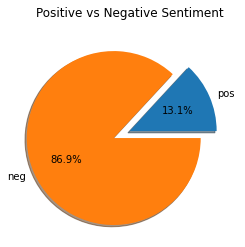

In [ ]:
pos = 0
neg = 0
for i in what["reddit_sentiment_label"]:
  if i == 1:
    pos += 1
  else:
    neg +=1
plt.pie([pos, neg], labels = ["pos", "neg"], autopct='%1.1f%%', explode = (0, 0.2), shadow=True )
plt.title("Positive vs Negative Sentiment")
plt.show()

## Google Trends

The Google trends data represents the value/ intrests of searchs associated with word bitcoin. 

In [ ]:
pytrend = TrendReq()
from pytrends import dailydata as dd

In [ ]:
df_daily_bitcoin = dd.get_daily_data("bitcoin",2014,1,2020,1,"US",True)
df_daily_bitcoin.head(50)

bitcoin:2014-01-01 2014-01-31
bitcoin:2014-02-01 2014-02-28
bitcoin:2014-03-01 2014-03-31
bitcoin:2014-04-01 2014-04-30
bitcoin:2014-05-01 2014-05-31
bitcoin:2014-06-01 2014-06-30
bitcoin:2014-07-01 2014-07-31
bitcoin:2014-08-01 2014-08-31
bitcoin:2014-09-01 2014-09-30
bitcoin:2014-10-01 2014-10-31
bitcoin:2014-11-01 2014-11-30
bitcoin:2014-12-01 2014-12-31
bitcoin:2015-01-01 2015-01-31
bitcoin:2015-02-01 2015-02-28
bitcoin:2015-03-01 2015-03-31
bitcoin:2015-04-01 2015-04-30
bitcoin:2015-05-01 2015-05-31
bitcoin:2015-06-01 2015-06-30
bitcoin:2015-07-01 2015-07-31
bitcoin:2015-08-01 2015-08-31
bitcoin:2015-09-01 2015-09-30
bitcoin:2015-10-01 2015-10-31
bitcoin:2015-11-01 2015-11-30
bitcoin:2015-12-01 2015-12-31
bitcoin:2016-01-01 2016-01-31
bitcoin:2016-02-01 2016-02-29
bitcoin:2016-03-01 2016-03-31
bitcoin:2016-04-01 2016-04-30
bitcoin:2016-05-01 2016-05-31
bitcoin:2016-06-01 2016-06-30
bitcoin:2016-07-01 2016-07-31
bitcoin:2016-08-01 2016-08-31
bitcoin:2016-09-01 2016-09-30
bitcoin:20

,bitcoin_unscaled,bitcoin_monthly,isPartial,scale,bitcoin
date,,,,,
2014-01-01,49,8.0,False,0.08,3.92
2014-01-02,57,8.0,NaN,0.08,4.56
2014-01-03,56,8.0,NaN,0.08,4.48
2014-01-04,53,8.0,NaN,0.08,4.24
2014-01-05,62,8.0,NaN,0.08,4.96
2014-01-06,74,8.0,NaN,0.08,5.92
2014-01-07,61,8.0,NaN,0.08,4.88
2014-01-08,75,8.0,NaN,0.08,6.00
2014-01-09,65,8.0,NaN,0.08,5.20


In [ ]:
help(dd.get_daily_data)

Help on function get_daily_data in module pytrends.dailydata:

get_daily_data(word: str, start_year: int, start_mon: int, stop_year: int, stop_mon: int, geo: str = 'US', verbose: bool = True, wait_time: float = 5.0) -> pandas.core.frame.DataFrame
    Given a word, fetches daily search volume data from Google Trends and
    returns results in a pandas DataFrame.
    
    Details: Due to the way Google Trends scales and returns data, special
    care needs to be taken to make the daily data comparable over different
    months. To do that, we download daily data on a month by month basis,
    and also monthly data. The monthly data is downloaded in one go, so that
    the monthly values are comparable amongst themselves and can be used to
    scale the daily data. The daily data is scaled by multiplying the daily
    value by the monthly search volume divided by 100.
    For a more detailed explanation see http://bit.ly/trendsscaling
    
    Args:
        word (str): Word to fetch daily

In [ ]:
df_daily_bitcoin.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2222 entries, 2014-01-01 to 2020-01-31
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bitcoin_unscaled  2222 non-null   int64  
 1   bitcoin_monthly   2222 non-null   float64
 2   isPartial         73 non-null     object 
 3   scale             2222 non-null   float64
 4   bitcoin           2222 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 184.2+ KB


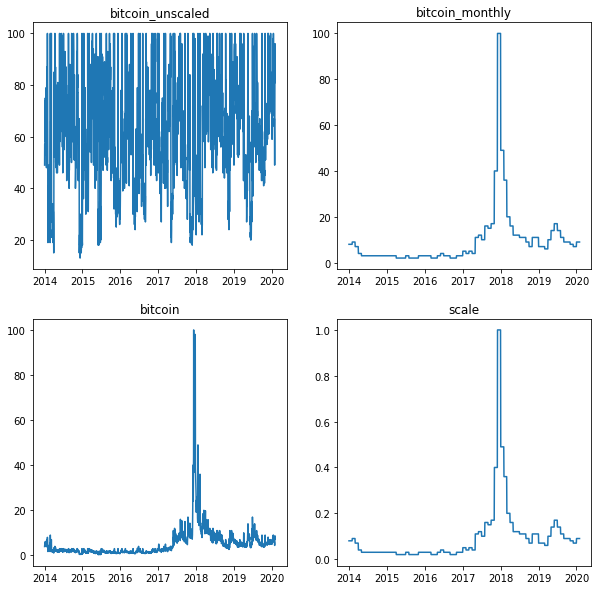

In [ ]:

# Create four polar axes and access them through the returned array
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0, 0].plot(df_daily_bitcoin["bitcoin_unscaled"])
axs[0, 0].set_title("bitcoin_unscaled")
axs[0, 1].plot(df_daily_bitcoin["bitcoin_monthly"])
axs[0, 1].set_title("bitcoin_monthly")
axs[1, 0].plot(df_daily_bitcoin["bitcoin"])
axs[1, 0].set_title("bitcoin")
axs[1, 1].plot(df_daily_bitcoin["scale"])
axs[1, 1].set_title("scale")
plt.show()


In [ ]:
df_daily_bitcoin.to_csv("/content/drive/MyDrive/CIS 522 Final Project/Data/goole_trends_bitcoin.csv")

## Twitter Data

The Data is scrapped from [bitinfocharts](https://bitinfocharts.com/comparison/tweets-btc.html). The data just contains the count of twitter posts associated with mentions of word bitcoin

In [ ]:
# Get # of daily tweets about bitcoin from: https://bitinfocharts.com/comparison/tweets-btc.html
# https://stackoverflow.com/questions/59395294/how-to-scrap-data-from-chart-on-https-bitinfocharts-com

def parse_strlist(sl):
    clean = re.sub("[\[\],\s]","",sl)
    splitted = re.split("[\'\"]",clean)
    values_only = [s for s in splitted if s != '']
    return values_only


url = 'https://bitinfocharts.com/comparison/tweets-btc.html'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

scripts = soup.find_all('script')
for script in scripts:
    if 'd = new Dygraph(document.getElementById("container")' in script.text:
        StrList = script.text
        StrList = '[[' + StrList.split('[[')[-1]
        StrList = StrList.split(']]')[0] +']]'
        StrList = StrList.replace("new Date(", '').replace(')','')
        dataList = parse_strlist(StrList)

date = []
tweet = []
for each in dataList:
    if (dataList.index(each) % 2) == 0:
        date.append(each)
    else:
        tweet.append(each)

twitter_df = pd.DataFrame(list(zip(date, tweet)), columns=["date","twitter_posts"])

In [ ]:
twitter_df['date'] = twitter_df['date'].str.replace('/','-')

In [ ]:
twitter_df = twitter_df.set_index("date")

In [ ]:
twitter_df.to_csv("/content/drive/MyDrive/CIS 522 Final Project/Data/twitter_data.csv")